<div class="usecase-title">Bin Fill Levels during events at Argyle Square - User interactive</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>
<div class="usecase-duration"><b>Duration: </b>90 mins</div>
<div class="usecase-level"><b>Level: </b>Intermediate</div>
<div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>

<div class="usecase-section-header">Scenario</div>

 
1. I am planning an event at Argyle Square and need to know if there will be sufficient waste collection space in the bins.

2. I am a waste collection planner and need to know if after an event the existing bins will need additional collection dates.

<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Filtering of dataframes
- Use of date time to resample data by different time increments
- Create box plots from a dataframe to identify variable relationships
- Create scatterplots from a dataframe to identify variable relationships
- Create pairplots from a dataframe to identify variable relationships
- Use Pearson correlation heatmap to identify linear variable relationships
- Use distance calculation to identify non-linear variable relationships
- Linear regression for predictive analysis
- Random Forest for predictive analysis
- Calculate feature importance, r-squared value and accuracy from predictive analysis
- Use input function to allow user interaction

<div class="usecase-section-header">How predicting Bin Fill Levels can be useful</div>

{Write your introduction here. Keep it concise. We're not after "War and Peace" but enough background information to inform the reader on the rationale for solving this problem or background non-technical information that helps explain the approach. You may also wish to give information on the datasets, particularly how to source those not being imported from the client's open data portal.}



<div class="usecase-section-header">Relevant Datasets</div>

[Blix Visits](https://data.melbourne.vic.gov.au/explore/dataset/blix-visits/information/)

- The Blix Visits data uses mobile phone counting to count the number of phones in a location. This dataset reports data at 3 minute intervals for each sensor; including a total count, dwell time and average dwell time (in minutes) of individual mobile phones. The blix sensors at Argle Square are the only ones of interest, so the data will be filtered at venueId 7780, Argyle Square. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Argyle Square Sound Stage Activity](https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-3/information/)
- The sound stage at Argyle Park has been fitted with three Elsys sensors to monotor movement on the stage. This data is reported every 3 minutes and includes an interger measurement value of motion and visit. In addition, the sensors also measure and report environmental data of temperature, humidity and light. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Netvox R718X Bin Sensor](https://data.melbourne.vic.gov.au/explore/dataset/netvox-r718x-bin-sensor/information/?disjunctive.dev_id)
- Netvox R718X measures distance using an ultrasonic ranging, which is used to calculate the bin fill level reported in the bin sensor data set. These levels are recorded hourly. This dataset aso reports the senros name, location and timedate data for the reading. Temperature and battery level are also recorded but not used in this use case. There are many bins across Argyle Square using this technology, but only bins from the area adjactent to the sound stage have been included in this investigation. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

#### REQUIRED MODULES

In [13]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore")

# Import required modules
import requests
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import statistics

#### IMPORT DATASETS

Import datasets using API v2.1 GET request with /exports/

In [14]:
from io import StringIO

# Function to collect datasets using API
def datasetcollect(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = " "
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [15]:
# Import stage activity dataset
dataset_id = 'meshed-sensor-type-3'
stage_activity_all = datasetcollect(dataset_id)
print(len(stage_activity_all))
stage_activity_all.head(3)

358990


,dev_id,sensor_name,time,temperature,humidity,light,motion,visit,vdd,lat_long
0,ers-55eb,NaN,2022-12-13T20:09:42+00:00,10.5,89,297,0,0,3638,NaN
1,ers-55ea,NaN,2022-12-13T20:26:03+00:00,10.6,88,136,0,0,3635,NaN
2,ers-55eb,NaN,2022-12-13T20:34:47+00:00,10.8,89,698,0,0,3638,NaN


In [16]:
# Import bin sensor dataset
dataset_id = 'netvox-r718x-bin-sensor'
bin_sensor_all = datasetcollect(dataset_id)
print(len(bin_sensor_all))
bin_sensor_all.head(3)

572254


,dev_id,time,temperature,distance,filllevel,battery,lat_long,sensor_name,fill_level
0,r718x-6778,2023-02-26T08:16:47+00:00,19.0,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
1,r718x-6f16,2023-02-26T08:18:10+00:00,19.9,202.0,74.0,3.6,"-37.8028794, 144.9662728",r718x-bin sensor 17,72.0
2,r718x-677d,2023-02-26T08:18:02+00:00,20.7,200.0,74.0,3.6,"-37.8021051, 144.9654523",r718x-bin sensor 11,72.0


In [17]:
# Import blix mobile phone counter dataset
dataset_id = 'blix-visits'
blix_phones_all = datasetcollect(dataset_id)
print(len(blix_phones_all))
blix_phones_all.head(3)

110759


,datetime,keys1,total,dwell,sensor_name,sensor_type,lat_long,avg_dwell
0,2022-08-25T22:00:00+00:00,8171,27,5697,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",3.0
1,2022-08-26T08:00:00+00:00,8171,115,42090,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",6.0
2,2022-08-26T02:00:00+00:00,7780,228,94848,Pedestrian Sensor-Argyle Sq,Mobile phone counting,"-37.8025805, 144.9656012",6.0


#### DATA PREPPROCESSING

Preprocessing of datasets involves deleting unwanted columns, converting data types, resampling withing common dateframes, filtering rows in datasets by variables, resmapling using date time.

In [139]:
# Delete unwanted columns from datasets

# Drop columns from stage_activity dataframe
stage_activity = stage_activity_all[['dev_id','time','motion','visit','temperature','humidity','light']]
# Drop columns from stage_activity dataframe
bin_sensor_cols = bin_sensor_all[['dev_id','time','filllevel']]
# Drop columns from stage_activity dataframe
blix_phones = blix_phones_all[['datetime','keys1','total','dwell','avg_dwell']]

In [140]:
# check data types in columns

print("Data types in Stage activity")
print(stage_activity.dtypes)

print("Data types in Bin Sensor")
print(bin_sensor_cols.dtypes)

print("Data types in Blix Phones")
print(blix_phones.dtypes)

Data types in Stage activity
dev_id          object
time            object
motion           int64
visit            int64
temperature    float64
humidity         int64
light            int64
dtype: object
Data types in Bin Sensor
dev_id        object
time          object
filllevel    float64
dtype: object
Data types in Blix Phones
datetime      object
keys1          int64
total          int64
dwell          int64
avg_dwell    float64
dtype: object


In [141]:
# convert date time columns to date time type

stage_activity['date_time'] = pd.to_datetime(stage_activity['time'])
stage_activity = stage_activity.drop(['time'], axis=1)

bin_sensor_cols['date_time'] = pd.to_datetime(bin_sensor_cols['time'])
bin_sensor_cols = bin_sensor_cols.drop(['time'], axis=1)

blix_phones['date_time'] = pd.to_datetime(blix_phones['datetime'])
blix_phones = blix_phones.drop(['datetime'], axis=1)

In [142]:
#Check oldest and most recent dates in datasets

print("Date range in stage activity")
print(stage_activity["date_time"].min())
print(stage_activity["date_time"].max())

print("Date range in bin sensor")
print(bin_sensor_cols["date_time"].min())
print(bin_sensor_cols["date_time"].max())

print("Date range in blix phones")
print(blix_phones["date_time"].min())
print(blix_phones["date_time"].max())

Date range in stage activity
2022-11-29 06:05:16+00:00
2024-04-07 08:07:55+00:00
Date range in bin sensor
2023-02-26 08:16:37+00:00
2024-04-07 08:11:38+00:00
Date range in blix phones
2021-12-31 13:00:00+00:00
2024-04-06 12:00:00+00:00


In [143]:
# Drop rows so that all datasets have the same date range

stage_activity= stage_activity[(stage_activity['date_time'] > '2023-2-26') & (stage_activity['date_time'] <= '2024-3-26')]

bin_sensor= bin_sensor_cols[(bin_sensor_cols['date_time'] > '2023-2-26') & (bin_sensor_cols['date_time'] <= '2024-3-26')]

blix_phones= blix_phones[(blix_phones['date_time'] > '2023-2-26') & (blix_phones['date_time'] <= '2024-3-26')]


In [144]:
# BIN DATASET PREPROCESSING
# Filter unwanted values from bin dataset 

# Keep only rows with bin sensors in the stage area
filtered_bin_sensor = bin_sensor_cols[bin_sensor_cols["dev_id"].isin(["r718x-6778", "r718x-6775","r718x-6f25","r718x-677e","r718x-6f31"])]
filtered_bin_sensor.head(3)

# Check max and min values in bin fill levels
# Max and min of filllevel column
print(filtered_bin_sensor['filllevel'].agg(['min', 'max']))

# Count the number of values greater than 100 in the bin fill coumns
more = len(filtered_bin_sensor[filtered_bin_sensor['filllevel']>100])

# Fnd percentage of values impacted  by value >100 in fill level
# Count the number of rows in the dataframe
total = len(filtered_bin_sensor)
#check the length of the dataframe
print(len(filtered_bin_sensor))
# Calculate the percentage of data that has values greater than 100
print(more/total)

# As only 0.0456% of data is impacted by data inaccuracies, make the decision to drop these rows from the table.

# Drop rows where bin fill column is greater than 100
filtered_bin_sensor = filtered_bin_sensor.drop(filtered_bin_sensor[filtered_bin_sensor['filllevel'] > 100].index)
# Check the length of the dataframe
len(filtered_bin_sensor)


min      0.0
max    255.0
Name: filllevel, dtype: float64
136256
0.00044768670737435417


136195

In [145]:
# BIN DATASET PREPROCESSING: RESAMPLE HOURLY FILLLEVEL MAX WITHOUT GROUPING BY BIN

# Set index to datetime column
filtered_bin_sensor.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_bin_sensor1 = filtered_bin_sensor.resample('H').filllevel.max()
grouped_bin_sensor1.head(3)

date_time
2023-02-26 08:00:00+00:00    74.0
2023-02-26 09:00:00+00:00    74.0
2023-02-26 10:00:00+00:00    74.0
Freq: H, Name: filllevel, dtype: float64

In [146]:
# STAGE ACTIVITY DATASET PREPROCESSING: RESAMPLE HOURLY MAX WITHOUT GROUPING BY SENSOR

# Set index to datetime column
stage_a = stage_activity
stage_a.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_stage_activity = stage_a.resample('H').agg({'motion':'max','temperature':'mean','humidity':'mean','light':'mean'})
grouped_stage_activity.head(3)

,motion,temperature,humidity,light
date_time,,,,
2023-02-26 00:00:00+00:00,0.0,21.913333,56.900000,2080.466667
2023-02-26 01:00:00+00:00,1.0,23.612500,51.156250,2187.687500
2023-02-26 02:00:00+00:00,1.0,24.703226,49.322581,2069.096774


In [147]:
# Merge grouped bin sensor and stage activity
merged_dataframe_A = pd.merge(grouped_bin_sensor1, grouped_stage_activity, on="date_time",how='outer')
merged_dataframe_A.head(3)

,filllevel,motion,temperature,humidity,light
date_time,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333


In [148]:
# BLIX_PHONE DATASET PREPROCESSING: Filter unwated data

# Keep only rows with sensores in the stage area
filtered_blix_phone = blix_phones[blix_phones["keys1"].isin([7780])]
filtered_blix_phone.head(3)

,keys1,total,dwell,avg_dwell,date_time
32826,7780,223,44377,3.0,2023-02-26 07:00:00+00:00
32828,7780,237,88638,6.0,2023-02-26 06:00:00+00:00
32833,7780,186,72726,6.0,2023-02-26 05:00:00+00:00


In [149]:
# BLIX PHONES DATASET ALREADY SAMPLED BY HOUR

# Set filtered_blix_phones index to datetime column
filtered_blix_phone.set_index('date_time', inplace=True)

In [169]:
# Merge dataframes

# Merge grouped stage activity, grouped bin sensor and grouped blix phones
merged_dataframe = pd.merge(merged_dataframe_A, filtered_blix_phone[['total','dwell','avg_dwell']], on="date_time",how='outer')
merged_dataframe.head(3)

,filllevel,motion,temperature,humidity,light,total,dwell,avg_dwell
date_time,,,,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,46020.0,4.0
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,37949.0,4.0
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,15708.0,3.0


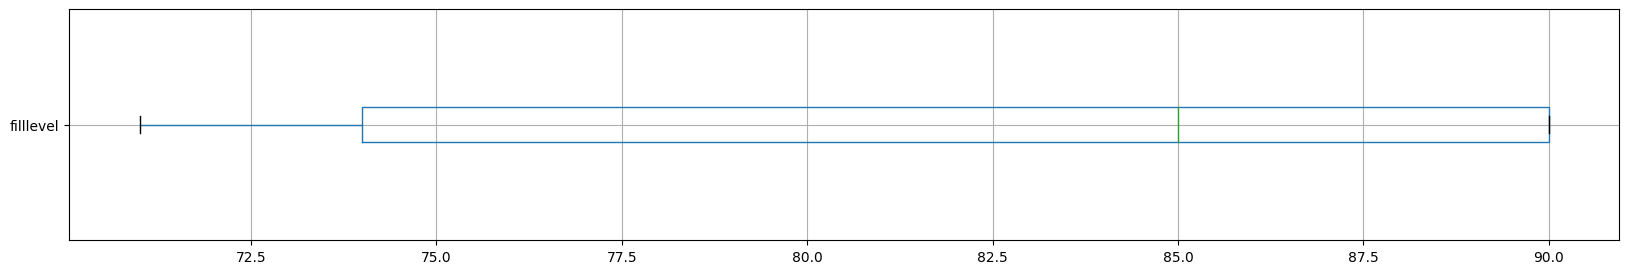

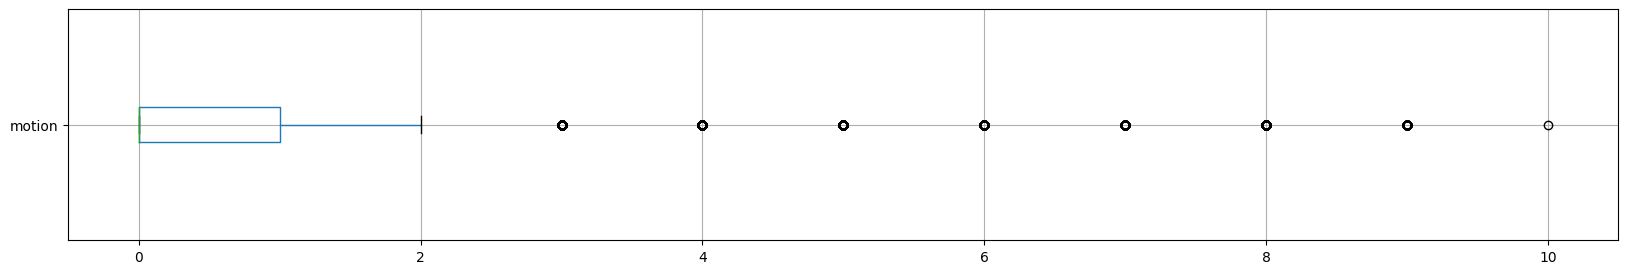

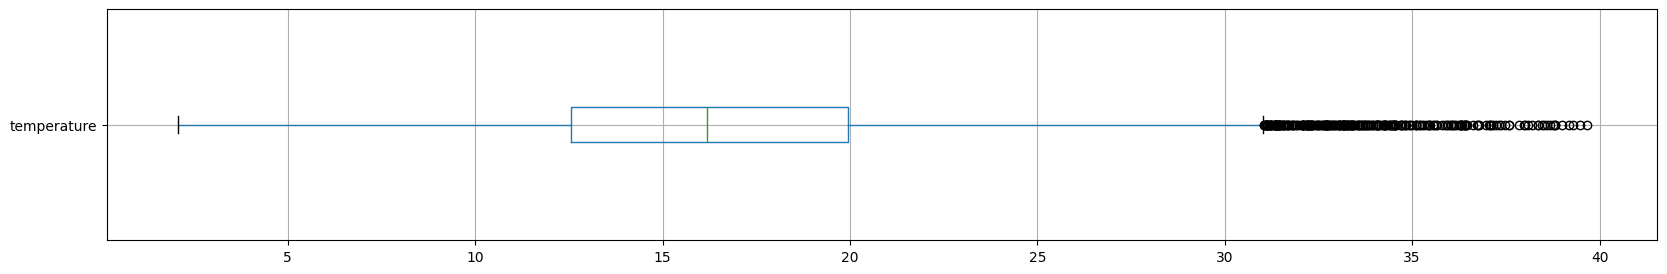

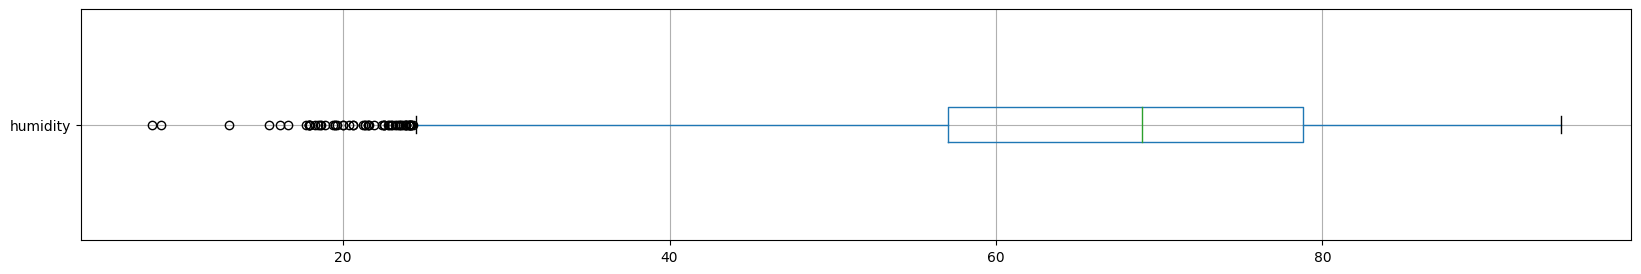

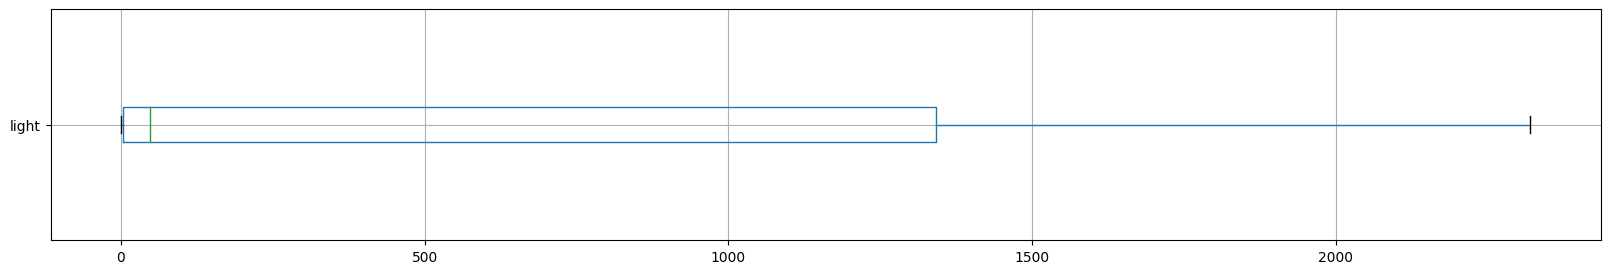

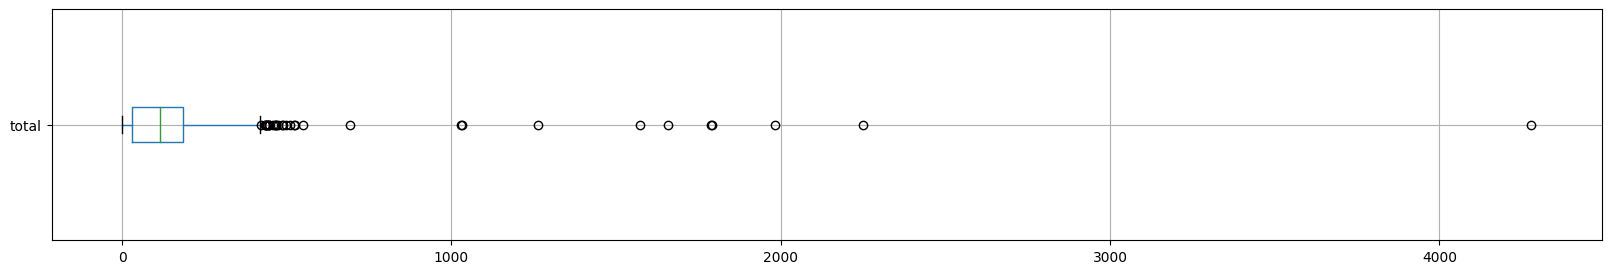

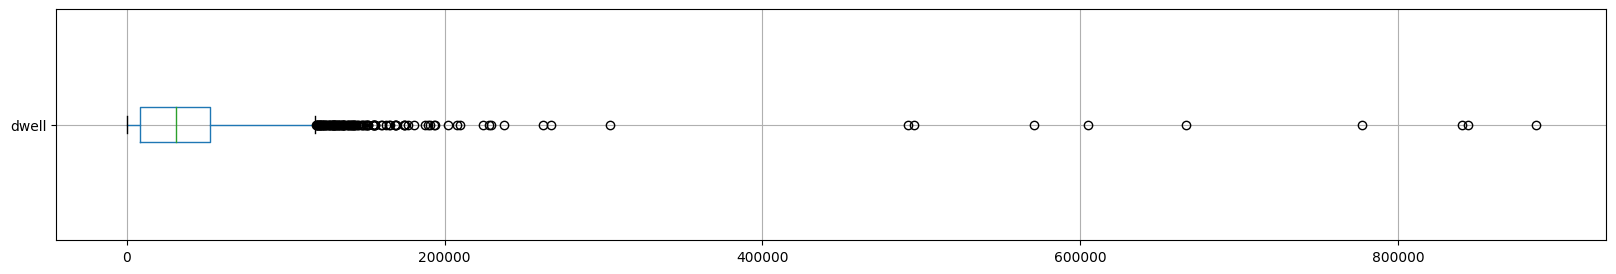

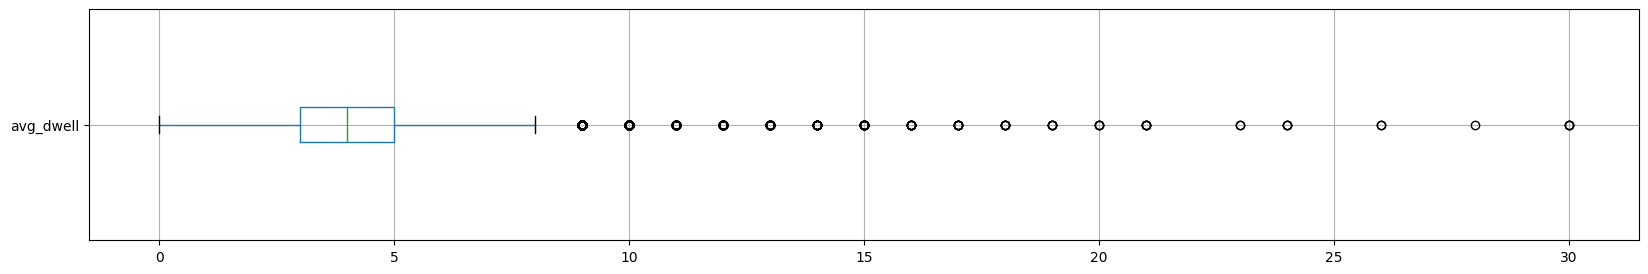

In [151]:
# Use box plots to check for any unexpected values in data

# Iterate over columns and create a horizontal box plot for each one
for column in merged_dataframe:
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure()
    merged_dataframe.boxplot([column], vert=False)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

The box plots show that there are outliers in most of the columns of data. As there are outliers in total they would be expected in dwell and total_dwell, as big events do not occur often. Weather outliers will also be kept as these numbers are seen to make sense in their datasets.

#### FEATURE CORRELATION

In [170]:
# Add index column
merged_dataframe = merged_dataframe.reset_index()

Scatterplots are used to identify if there are relationshsips between each varaible and time.

In [202]:
# Shorten variable for merged dataframe to make code shorter
fmd = merged_dataframe

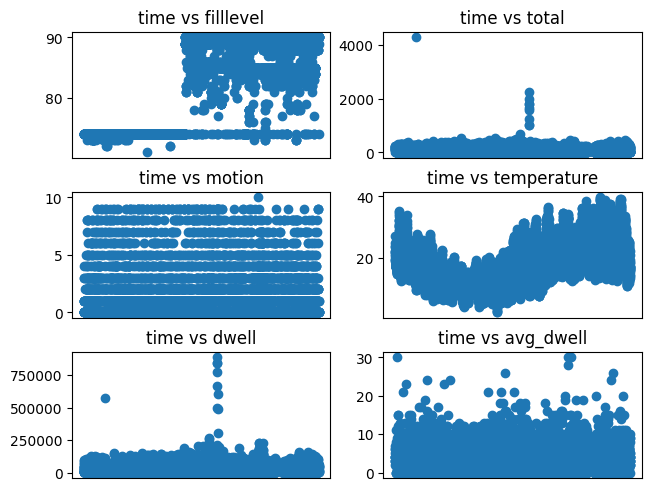

In [188]:
# Create scatter plots of datetime vs all other variables
fig, ax = plt.subplots(3, 2,constrained_layout = True)
# Create a plot of time vs filllevel
plt.subplot(3,2,1)
plt.scatter(fmd['date_time'], fmd['filllevel'])
plt.title("time vs filllevel")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs total
plt.subplot(3,2,2)
plt.scatter(fmd['date_time'],fmd['total'])
plt.title("time vs total")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs motion
plt.subplot(3,2,3)
plt.scatter(fmd['date_time'],fmd['motion'])
plt.title("time vs motion")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs temperature
plt.subplot(3,2,4)
plt.scatter(fmd['date_time'], fmd['temperature'])
plt.title("time vs temperature")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs dwell
plt.subplot(3,2,5)
plt.scatter(fmd['date_time'],fmd['dwell'])
plt.title("time vs dwell")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs avg_dwell
plt.subplot(3,2,6)
plt.scatter(fmd['date_time'], fmd['avg_dwell'])
plt.title("time vs avg_dwell")
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


From the scatterplots against time, the relationships evident are that of time against average dwelling and time against motion. All other variable pairs have no clear pattern. Pairplots will be used to investigate the relationship between all other variables.

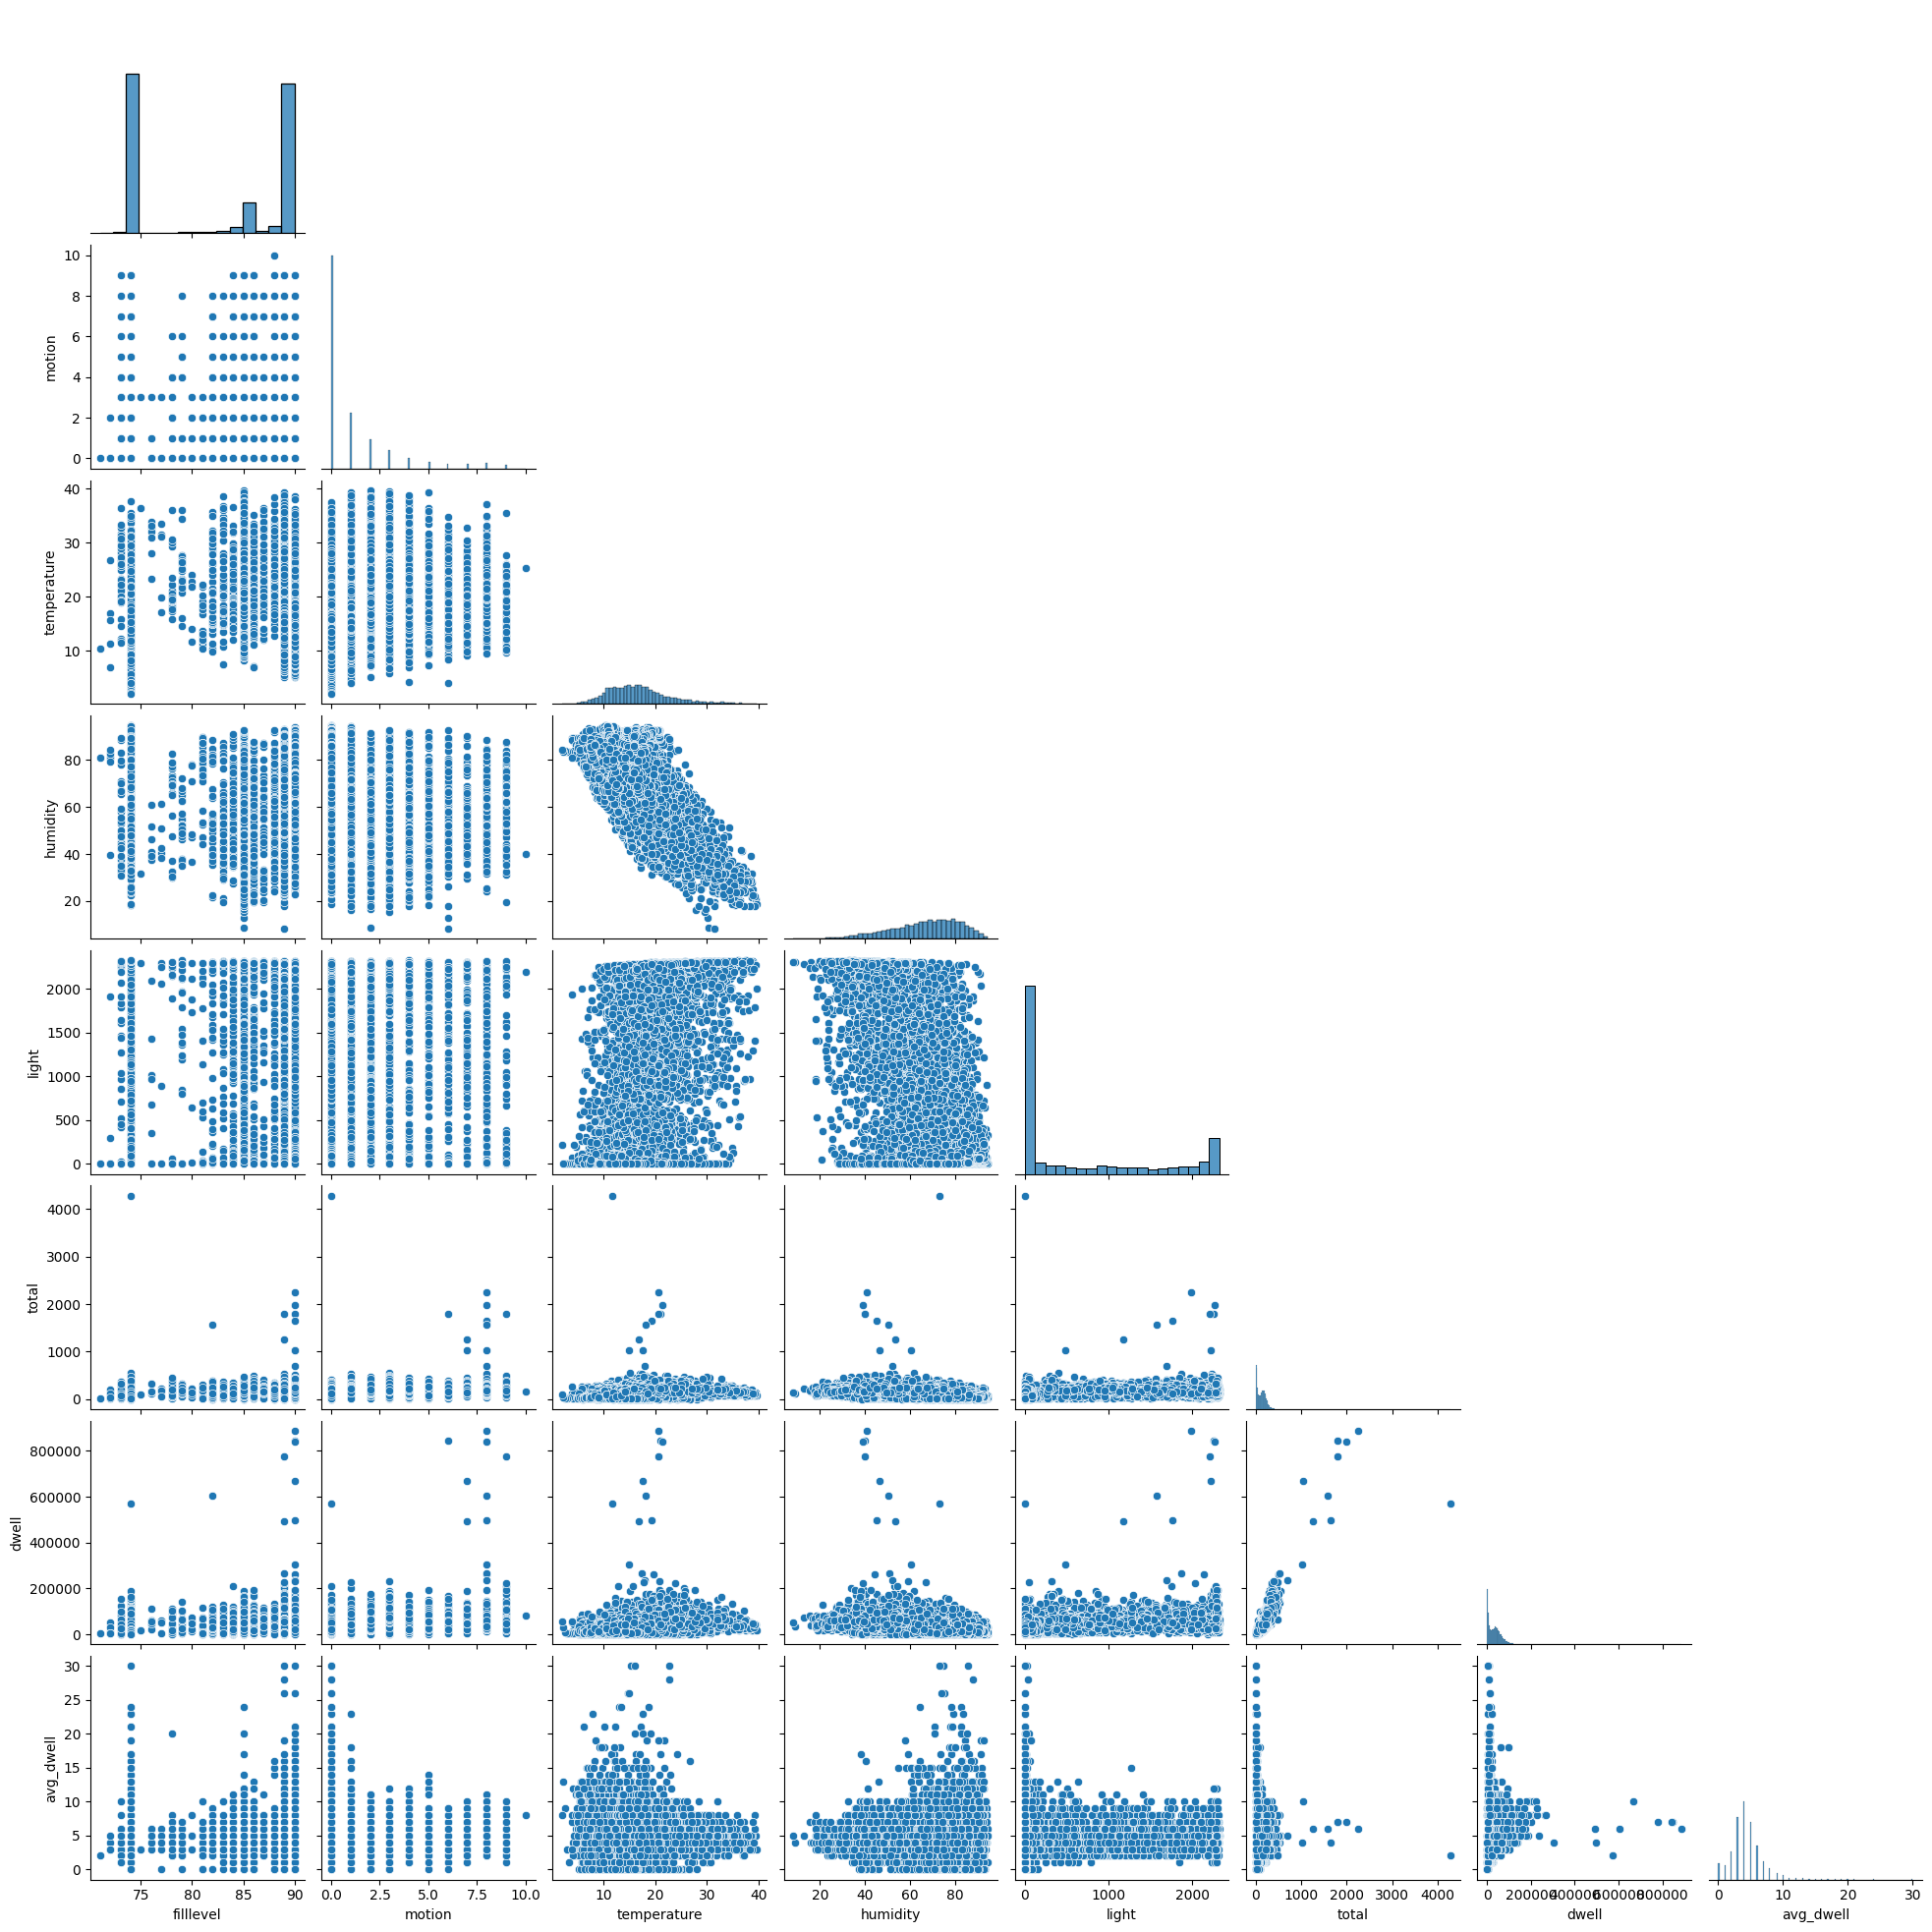

In [203]:
# Create a pairsplot to look at relationships between other variables
fmd.reset_index(drop=True, inplace=True)
sns.pairplot(fmd, corner=True)
plt.show()

The pairs plot shows a relationship between some variables. Temperature, humidity and light have the strongest relationship. The strongest linear relationship is between total and dwell. The pairs plots only compare numerical data.

Pearson correlation is used to determine extent of linear relationship between each pair of variables. 

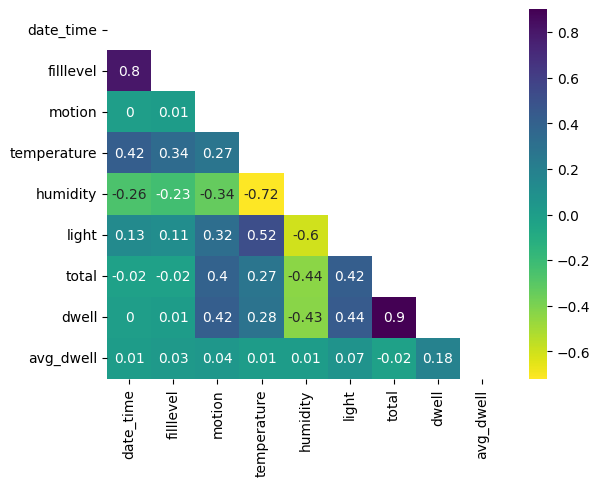

In [190]:
# Calculate correlation heatmap for all columns
matrix = fmd.corr(method = 'pearson').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, cmap='viridis_r', mask=mask)

plt.show()

The correlation heatmap shows the extent of the linear relationship between variables. In this investigation the focus is on the relationship between fill level and other variables. The highest linear relationship is between fill level and time, at 0.8 positive linear relationship. Next is temperature and bin fill level, with has a medium negative linear correlation of 0.34, followed by other weather related variables. Motion, dwelling and total are seen to have weak negative linear relationships with bin filllevel.  

As few variables exhibit a strong linear relationship in the heatmap or pairplot, the existance of non-linear relationships should also be measured. The Distance Correlation uses the dcor package to help capture the extent of non-linear correlation between variables. As bin filllevel is the main variable of interest, measurements of each varaibles correlation to filllevel will be calculated. It is important to note that date time is not supported in the distance calculation function.

In [191]:
# Calculated non-linear distance correlation between all variables and bin filllevel

# Drop rows with na values (not supported in dcor package)
no_na_fmdd = fmd.dropna(axis=0, how='any')

# Calculate distance correlation between numerical variables and bin fill level (Datetime not supported)
print("filllevel and total =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['total']))
print("filllevel and dwell =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['dwell']))
print("filllevel and avg_dwell =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['avg_dwell']))
print("filllevel and motion =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['motion']))
print("filllevel and temperature =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['temperature']))
print("filllevel and humidity =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['humidity']))
print("fillevel and light =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['light']))


filllevel and total = 0.04737522769314353
filllevel and dwell = 0.041870152242495275
filllevel and avg_dwell = 0.041818008373482825
filllevel and motion = 0.04396768938162847
filllevel and temperature = 0.3672145472802947
filllevel and humidity = 0.23947464320190792
fillevel and light = 0.12140752151312754


The strongest non-linear correlations measured remain between bin filllevel and weather variables of temperature, humidity and light. As with the linear correlation measurement, the distance correlation also finds slight non-linear relationships between total, dwell and motion.

#### PREDICTIVE MODELLING

Preprocessing data for predictive models

In [192]:
# Set the x and y variables. Drop date_time as it is not supported by linear or random forest
X = no_na_fmdd.drop(["filllevel",'date_time'], axis=1)
y = no_na_fmdd["filllevel"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [193]:
# Make function to analyse accuracy of predictions
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = round(correct_predictions/len(y_true)*100,2)
    print(f"The accuracy of this model is {accuracy}%")

Predictive model - Linear Regression

The importance of feature motion is -22.08%.
The importance of feature temperature is 44.41%.
The importance of feature humidity is -4.18%.
The importance of feature light is -0.06%.
The importance of feature total is -1.05%.
The importance of feature dwell is 0.0%.
The importance of feature avg_dwell is 4.59%.


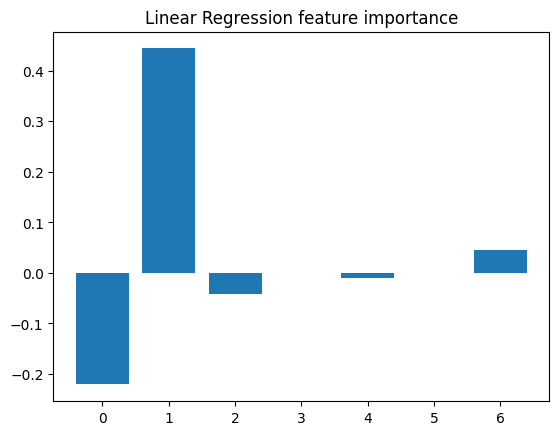

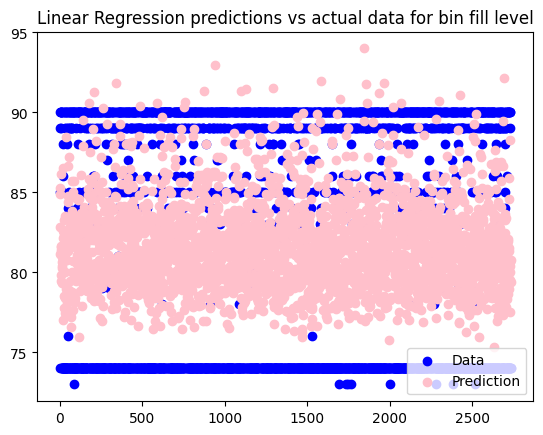

The accuracy of this model is 0.0%
R-squared value for Linear Regression is 0.13783913817510807


In [194]:
# Initiate Linear Regression
lr_model = LinearRegression()

# Train model on training data
lr_model.fit(X_train, y_train)

# Report on the importance of each feature used in the analysis
lr_importance = lr_model.coef_
columns = X.columns
i = 0
while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(lr_importance[i]*100,2)}%.")
    i += 1

# plot feature importance
plt.bar([x for x in range(len(lr_importance))], lr_importance)
plt.title("Linear Regression feature importance")
plt.show()

# Make predictions of test data using the model
lr_predictions = lr_model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue',label='Data')
plt.scatter(range(len(lr_predictions)), lr_predictions, color='pink',label='Prediction')
plt.title("Linear Regression predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, lr_predictions)

# Calculate the r2 value for the model
r2_score = lr_model.score(X, y)
print(f"R-squared value for Linear Regression is {r2_score}")

The linear Regresison model aims to predict the values in the bin fill level column from the linear relationship with the all other numerical variables; motion, temperature, humidity, light, total, dwell and avg_dwell. The table and bar graph report the importance of each feature in the calculation of bin fill level. The most influential variable is temperature, at 44.41%, followed by motion at -22.08% and avg_dwell at 4.59%. All other variables contribute less than 2% to the Linear Regression model.
Model performance is evaluated using a scatterplot as well as accuracy and r-squared calculations. The scatterplot compares the predictions from the model with the actual values from the dataset. From this plot it is seen that the Linear Regression analysis has a tendency to return high bin fill levels, as there are no predictions below 75% full.
The accuracy of the model is calculated by dividing the total number of times the prediction exactly matches the data value in the table and dividing by the total number of predictions. The Linear Regression model made 0 accurate predictions. The r-squared value is also low, at 0.13, meaning that the Linear Regression model explains very little of the variation in the bin fill level variable around its mean.


Predictive model - Random Forest Classification

The importance of feature motion is 4.28%.
The importance of feature temperature is 22.13%.
The importance of feature humidity is 17.83%.
The importance of feature light is 21.92%.
The importance of feature total is 13.23%.
The importance of feature dwell is 14.07%.
The importance of feature avg_dwell is 6.55%.


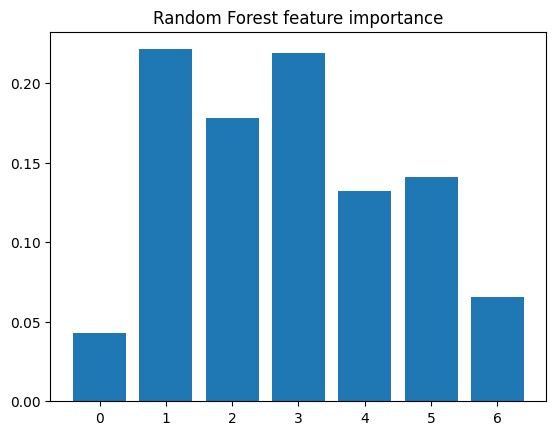

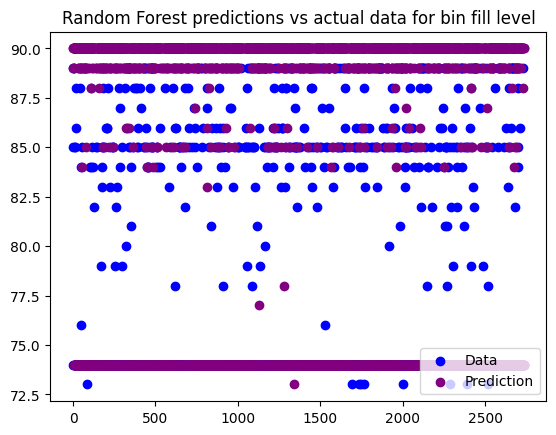

The accuracy of this model is 59.45%
R-squared value for Random Forest is 0.8783457656867047


In [195]:
# Initiate the Random Forest classifier
estimators = 88
rf_model = RandomForestClassifier(n_estimators=estimators, random_state=44)

# Train model on training data
rf_model.fit(X_train, y_train)

# Report on the importance of each feature used in the analysis
rf_importance = rf_model.feature_importances_
columns = X.columns
i = 0
while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(rf_importance[i]*100,2)}%.")
    i += 1

# plot feature importance
plt.bar([x for x in range(len(rf_importance))], rf_importance)
plt.title("Random Forest feature importance")
plt.show()

# Make predictions of test data using the model
rf_predictions = rf_model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(rf_predictions)), rf_predictions, color='purple',label='Prediction')
plt.title("Random Forest predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, rf_predictions)

# Calculate the r2 value for the model
r2_score = rf_model.score(X, y)
print(f"R-squared value for Random Forest is {r2_score}")

Random Forest model uses an ensemble of decision trees to predict the values in the bin fill level column using non-linear classification. As with the linear regression model, all other numerical variables are used to train the model; motion, temperature, humidity, light, total, dwell and avg_dwell. The table and bar graph report the importance of each feature in the calculation of bin fill level. Like Linear Regression, the most influential variable is temperature (22.13%), closely followed by the other environmental variables (humidity at 17.8% and light at 21.9%). Dewll and total follow contributing a significant 14% and 13% respectively. Motion and avg_dwell contribute less than 7% each. 
Model performance is again evaluated using a scatterplot as well as accuracy and r-squared calculations. The scatterplot shows a tendency for Random Forest to also return high bin fill levels, however it returns several low values as well.
The accuracy of the model is above 59%, meaning that about half the time it predicts the exact value from the dataset. The r-squared value is also high, above 0.87, meaning that the Random Forest model explains most of the variation in the bin fill level variable around its mean. As well as demonstrating good model performance, the benefit of using this model for predictions is that Random Forest is less likely to overfit data, even with smaller datasets.

#### MAKE PREDICTIONS FROM USER INPUT

Further preprocessing is used to resample data by month so that monthly averages for environmental variables of temperature, humidity and light can be calculated.


In [204]:
# Set up weather data for use in prediction
stage_weather = stage_activity_all

# Convert stage weather time column to date_time
stage_weather['date_time'] = pd.to_datetime(stage_weather['time'])
stage_weather = stage_weather.drop(['time'], axis=1)

# Set stage weather index to datetime column
stage_weather.set_index('date_time', inplace=True)

# Resample data by month to get average temperature, humidity and light
grouped_stage_weather = stage_weather.resample('M').agg({'temperature':'mean','humidity':'mean','light':'mean'})

# Add index back in
grouped_stage_weather.reset_index(inplace=True)

# Add new column month to dataframe
grouped_stage_weather['month'] = grouped_stage_weather['date_time'].dt.month

Linear regression will be used to estimate a value for dwell from the total entered by the user.

In [205]:
# linear regression for bin fill est function
# Set the x and y variables. Select only the total and dwell columns
X = no_na_fmdd['total']
y = no_na_fmdd['dwell']

# Reshape data as it has single features
X = pd.DataFrame(X)
y = pd.DataFrame(y)

# Train model on all data
lr_model.fit(X, y)

# Calculate and report r-squared value
r2_score = lr_model.score(X, y)
print(f"R-squared value for Linear Regression is {r2_score}")


R-squared value for Linear Regression is 0.804554551340983


The high r-squared value of 0.80 means that the total value explains most of the variation in the dwell variable. This means that linear regression is a good model to estimate dwell from using the total value.

In [206]:
# Random Forest model for bin fill est function
# Set the x and y variables. Drop date_time as it is not supported, and avg_dwell as it contributed little
A = no_na_fmdd.drop(["filllevel",'date_time','avg_dwell'], axis=1)
b = no_na_fmdd["filllevel"]

# Train the random forest model with the data
rf_model.fit(A, b)

RandomForestClassifier(n_estimators=88, random_state=44)

In [207]:
# Function to find average of a column
def get_weather_est(df, column):
    for column in column:
        columnSeriesObj = df[column]
        data = statistics.mean(columnSeriesObj.values)
        return data

In [210]:
# User entry of information to predict average bin fill level at the event

def bin_fill_est():
    # Set motion value to 3 as default for events
    motion = 3
 
    # User entry of date
    date = pd.to_datetime(input("Please type the event date in the format dd/mm/yyyy and press enter"))
    
    # Extract month number from user date entry
    month_number = int(date.month)
    # Select rows from weather dataframe based on user entry
    rslt_df = grouped_stage_weather.loc[grouped_stage_weather['month'] == month_number]
    # Save average values for weather data to variables using function defined above
    temp = get_weather_est(rslt_df,rslt_df[['temperature']])
    humid = get_weather_est(rslt_df,rslt_df[['humidity']])
    light = get_weather_est(rslt_df,rslt_df[['light']])

    # User entry of attendees
    attend = int(input("Please type the number of projected attendees and press enter"))
    
    # Save attend as a 2D array
    attend_array = [[attend]]
    # Use attendees to predict dwell value
    dwell_array = lr_model.predict(attend_array)
    # Save dwell value as single element
    dwell_array_1 = dwell_array[0]
    dwell = dwell_array_1[0]
    
    # Create array to store values calcualted in function
    data_for_prediction = [[motion,temp,humid,light,total,dwell]]
    # Call random forest to make prediction of bin fill level
    rf_array = rf_model.predict(data_for_prediction)
    # Save binfill value as single element
    binfill = rf_array[0]
    # Output bin level from function
    print(f"The estimated average bin fill level is {binfill}")


In [211]:
# Call the bin fill estimate function
bin_fill_est()

The estimated average bin fill level is 74.0


In [ ]:
#!jupyter nbconvert --to html usecase_TEMPLATE_COPY.ipynb